In [10]:
import os
import time
import glob
import dit
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import pandas as pd
from dit import Distribution
os.chdir("../")
from jointpdfpython3.params_matrix import params2matrix_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

# Plot 25 uniform and random X for jointpdf and syndisc

## load and run syndisc with previous pars (for 5 states)


In [11]:
run=False
if run:
    states=5
    initdata = pd.read_pickle("../../results/rq11/randomstates"+str(states)+".pkl")
    initdata=initdata[initdata['systemID'].isin([0,1,2,3,4])]
    pars = initdata['parXY'].values
    lenX=2
    variables_X=np.arange(lenX)
    data = {'systemID':[],'parXY':[],'pXS':[],'syn_upper':[],'runtime':[],'I(X;S)':[],'I(Xi;S)':[],'exp_sort':[]}
    for i,p in enumerate(pars):
        print(i,time.strftime("%H:%M:%S", time.localtime()))
        data['systemID'].append(i)
        data['parXY'].append(p)
        jX = JointProbabilityMatrix(lenX,states)
        params2matrix_incremental(jX,p)
        pX = jX.joint_probabilities.joint_probabilities
        upper = initdata['syn_upper'].iloc[i]    
        ditjX = dit.Distribution.from_ndarray(pX)
        try:
            before = time.time()
            syn, probs = self_disclosure_channel(ditjX)
            data['runtime'].append(time.time()-before)

            vgx = probs['pVgX']
            x = initdata['pX'].iloc[i]
            pXS = np.reshape((x*vgx).T, [states]*lenX+[len(x*vgx)])
            dit_XS = Distribution.from_ndarray(pXS)
            synvars = list(range(lenX,len(dit_XS.rvs)))
            data['pXS'].append(pXS)
            data['I(X;S)'].append(dit.shannon.mutual_information(dit_XS,variables_X,synvars))
            data['I(Xi;S)'].append(sum([dit.shannon.mutual_information(dit_XS,[i],synvars) for i in variables_X]))
        except:
            print("syndisc error")
            data['pXS'].append([])
            data['I(X;S)'].append(0)
            data['I(Xi;S)'].append(0)
        data['exp_sort'].append('syndisc')
        data['syn_upper'].append(upper)
            
    pddata = pd.DataFrame(data=data)
    pddata.to_pickle("../../results/test/syndiscrandomstates"+str(states)+".pkl") 


## load data and plot

In [12]:
lenX = 2
subjects=np.arange(lenX)

dist_type = 'uniformstates'
ds = []
folder = '../../results/rq11/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
if len(allfiles) != 0:
    name = dist_type
    files = [file for file in allfiles if name in file]
    print(files)
    for f in files:
        cur = pd.read_pickle(f)
        if 'syndiscrandomstates' in f:
            cur['states']=5
            cur['syn_info'] = cur['I(X;S)']
            cur['tot_runtime'] = cur['runtime']
        ds.append(cur)
os.chdir('../../code/plot_notebooks')
d = pd.concat(ds)
d = d[(d['states']!=5)|(d['systemID']<5)]
d.keys(),len(d)

['uniformstates2.pkl', 'uniformstates3.pkl', 'uniformstates4.pkl']


(Index(['exp_sort', 'systemID', 'syn_upper', 'shapeS', 'srv_data', 'pX',
        'parXY', 'H(Xi)', 'I(X1;X2)', 'runID', 'tot_runtime', 'syn_info',
        'lenX', 'lenY', 'states', 'dist_type', 'num_srvs', 'systems', 'prev',
        'exp', 'save', 'folder', 'rowfolder', 'tot_repeats', 'mm',
        'summed_modulo', 'tol'],
       dtype='object'),
 150)

C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Use

(-0.1, 1.1)

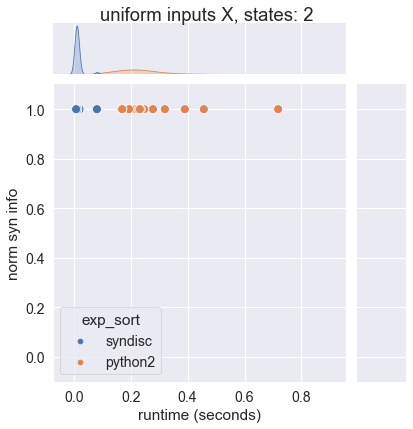

In [13]:
states=2
plot = d[d['states']==states]
plot['norm syn info'] = plot['syn_info']/plot['syn_upper']
if states == 5:
    xaxis='runtime (minutes)'
    plot[xaxis]=plot['tot_runtime']/60
else:
    xaxis='runtime (seconds)'
    plot[xaxis]=plot['tot_runtime']

yaxis='norm syn info'
hue='exp_sort'
sns.set_context("paper", font_scale = 1.6, rc={"grid.linewidth": 1})
f=sns.jointplot(data=plot,x=xaxis,y=yaxis,hue=hue,s=80)

if 'random' in name:
    title = "random inputs X, states: "+str(states)
else:
    title = "uniform inputs X, states: "+str(states)
f.fig.suptitle(title,y=1.0)

plt.ylim(-0.1,plot['syn_info'].max()+0.1)